In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt
import time
from IPython.display import Image

### 2 days left before you have to send pre-read materials 

#### TODO:
- formulate and implement a MIP to solve the same problem
- move certain functions to src code and clean up notebook
- consider changing wording of plant to vegetable or veg or produce or crop or provision

- fill in documentation to make this easier to walk through during the workshop
- make the simulated annealing an optional param so that you can show difference between local search and how SA improves it
- figure out some good pre-read materials
- email chris this notebook and let him decide if we should do both 

### Problem Statement:
Objectives:
- Maximize the total yield of the garden
- Maximize family satisfaction with what is planted in the garden
- Maximize variety of what is planted in the garden

Constraints:
- Can only plant 1 plant in a bed in a given year
- Cannot plant plant in a bed if the sun is not adequate
- Perennial plants must be assigned to the same bed year-over-year once they are planted

In [2]:
plant_info = pd.read_csv('../data/plant_data.csv')
bed_info = pd.read_csv('../data/bed_data.csv')

In [3]:
# plant_info = plant_info.head(5).copy()
# bed_info = bed_info.head(10).copy()

In [4]:
plant_info.index.name = 'plant_index'
plants = plant_info.plant.to_numpy()
plant_index = plant_info.index.to_numpy()
num_plants = len(plants)

In [5]:
bed_info.index.name = 'bed_index'
beds = bed_info.bed.to_numpy()
bed_index = bed_info.index.to_numpy()
num_beds = len(beds)

In [6]:
#time dimension
num_years = 3
year_index = np.array(range(num_years))
years = np.array(range(1,num_years+1))

In [7]:
#for keeping track of what axis is which
plant_axis = 0
bed_axis = 1
year_axis = 2

In [8]:
#list of perennial plant indices
perennials = plant_info[plant_info.perennial==1].index.to_list()

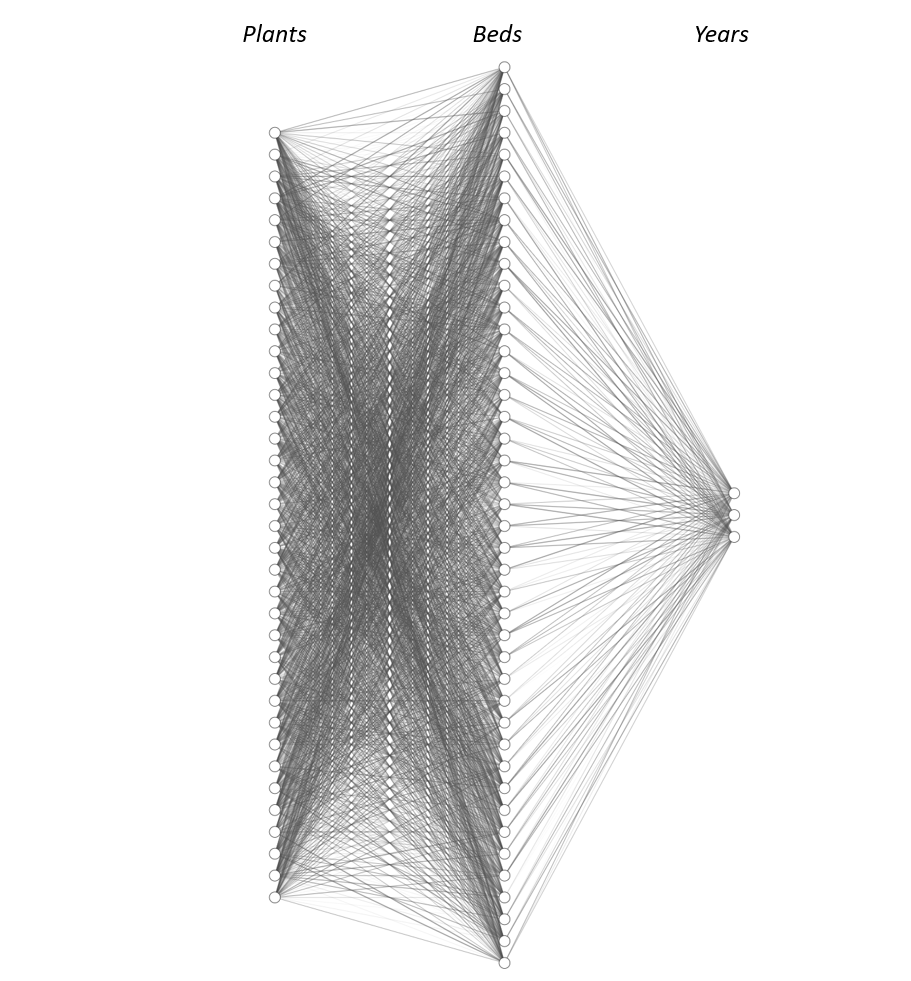

In [9]:
Image(os.path.join(os.getcwd(),'..','data','solution_space_viz.png'))

In [10]:
#average preference
family = ['evan','gina','liesse','lizzie','jack']
plant_info['avg_pref'] = np.average(plant_info[family],axis=1,weights=[.5,.5,0,0,0])
plant_info.drop(family,axis=1,inplace=True)
preferences = plant_info.avg_pref.to_numpy()
plant_index_by_pref = plant_info.sort_values('avg_pref',ascending=False).index 

In [11]:
#get plant and bed sun requirements
plant_sun_req = plant_info.sun.to_numpy()
bed_sun_req = bed_info.sun.to_numpy()

In [12]:
#initialize sun constraint
sun_constraint = np.ones(shape=(num_plants,num_beds,num_years))

for p in plant_index:
    for b in bed_index:
        p_sun = plant_sun_req[p]
        b_sun = bed_sun_req[b]
        if p_sun != b_sun:
            sun_constraint[p,b,:] = 0

In [13]:
#initialize plan. no plants in any bed
initial_plan = np.zeros(shape=(num_plants,num_beds,num_years))

#put a random crop in each bed
for bed in bed_index:
    plant = np.random.choice(plant_index)
    initial_plan[plant][bed] = 1
    
print(initial_plan[:,:,0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
initial_plan.shape

(36, 42, 3)

### Meta-Heuristics


![SA_Example](https://upload.wikimedia.org/wikipedia/commons/d/d5/Hill_Climbing_with_Simulated_Annealing.gif)

In [15]:
def make_neighbor(plan):
    """
    iteration: 
    cycle_size: 
    """
    #pick a random plant
    plant = np.random.choice(plant_index)
    #pick a random bed
    bed = np.random.choice(bed_index)
    #pick a random year
    year = np.random.choice(year_index)

    #implement decision
    new_plan = plan.copy()
    new_plan[:,bed,year] = np.zeros(shape=(num_plants)) #zero out previous decision for the bed in the year
    new_plan[plant,bed,year] = 1

    #forward fill if a perennial to make sure it remains in that bed
    if plant in perennials:
        new_plan[:,bed,year:] = 0 # zeros out anything else that may have been planted in bed in current and subsequent years during a previous make_neighbor call
        new_plan[plant,bed,year:] = 1 #sets plant to 1 in bed every year after the current year

    return new_plan

In [16]:
def enforce_perennial_constraint(plan,plant_info):
    return None

In [17]:
def enforce_sun_constraint(plan,sun_constraint):
    """
    !!!!update
    Scans beds and plants, kills any plant that is in a bed that does not match its sun requirement.
    """
    return plan*sun_constraint

In [18]:
def compute_yield(plan):
    """
    Yield is the % of plants that are planted and survive. Not all plants will survive where they are planted.
    This is where we impose constraints on sun requirements, year-over-year planting requirements, and companion planting requirements.
    Returns the total number of surviving plants / the total plants planted.
    """
    # 
    #Too little/too much sun can kill certain plants
    #Some plants don't do well depending on what was planted the year before
    #Some plants don't go well next to each other
    #denominator. total number of plants planted
    total_plants_planted = plan.sum()+1 #+1 avoids div by zero error  
    
    plan_yield = plan.copy()

    #impose constraints that kill plants in beds where they are not supposed to be
    plan_yield = enforce_sun_constraint(plan_yield,sun_constraint)
        
    # plan = yoy_planting_constraint(plan)
    # plan = companion_planting_constraint(plan)
    yield_ = round((plan_yield.sum()/total_plants_planted)*100,1)
    return plan_yield,yield_

def compute_yummy_score(plan,preferences):
    """Takes the weighted average of the preferences of each plant, weighted by the total qty of plants 
    in the current plan for each plant. Maximization encourages plants with higher preferences to be planted in higher quantities."""
    plan_yummy = plan.copy()
    plan_by_plant = plan_yummy.sum(axis=(bed_axis,year_axis))#/plan_yummy.sum() 
    yums = round(np.average(preferences,weights=plan_by_plant+1)*10,1) #+1 avoids div by 0
    return yums

def compute_variety_score(plan,num_plants):
    """Sums the number of unique plants that are actually planted in the garden. Counts the number of plants that are being planted across all beds.
       Then counts the number of plants with non-zero planting plan. 
       Maximization encourages more unique plants to be planted."""
    plan_variety = plan.copy()
    variety_score = round((plan_variety.sum(axis=bed_axis) > 0).sum()/num_plants*100,1)
    return variety_score

In [19]:
def get_objective(plan,weights,initial_obj_values):
    plan, yield_ = compute_yield(plan)
    yummy_score = compute_yummy_score(plan,preferences)
    variety_score = compute_variety_score(plan,num_plants)
    objective = (
                (weights['yield_']*yield_) / initial_obj_values['yield_']
              + (weights['yummy_score']*yummy_score) / initial_obj_values['yummy_score'] 
              + (weights['variety_score']*variety_score) / initial_obj_values['variety_score']
                )
    # return (objective,{'objective':objective,'yield_':yield_})
    return (objective,{'objective':objective,'yield_':yield_,'yummy_score':yummy_score,'variety_score':variety_score})

In [20]:
def optimize(initial_plan,weights,starting_temperature=10000,alpha=0.99,max_SA_iter=10000):
    
    initial_obj_values = {'yield_': compute_yield(initial_plan)[1],
                          'yummy_score': compute_yummy_score(initial_plan,preferences),
                          'variety_score': compute_variety_score(initial_plan,num_plants)}

    current_plan = initial_plan.copy()
    current_objective,current_obj_values = get_objective(initial_plan,weights,initial_obj_values)
    
    best_plan = initial_plan.copy()
    best_objective = current_objective

    current_plan_obj_values = [(0,current_obj_values)]
    best_obj_values = [(0,current_obj_values)]
    
    temperature = starting_temperature

    for i in range(max_SA_iter):
        # start = time.time()
        new_plan = make_neighbor(current_plan)
        # print('1:',(time.time()-start)*1000)
        # start = time.time()

        # print('2:',(time.time()-start)*1000)
        # start = time.time()
        new_objective,new_obj_values = get_objective(new_plan,weights,initial_obj_values)

        if new_objective > current_objective or np.exp(-(current_objective-new_objective) / temperature) > np.random.uniform():
            current_plan = new_plan.copy()
            current_objective = new_objective
            current_plan_obj_values.append((i,new_obj_values))
          
        # print('3:',(time.time()-start)*1000)
        # start = time.time()
        if new_objective > best_objective:
            best_plan = new_plan.copy()
            best_objective = new_objective
            best_obj_values.append((i,new_obj_values))      
        # print('4:',(time.time()-start)*1000)
        # start = time.time()
        #lower the temperature
        temperature = temperature*alpha        
    
    return best_plan,best_objective,best_obj_values,current_plan_obj_values

In [21]:
weights = {'yield_':        .0,
           'yummy_score':     1,
           'variety_score': .0}

In [22]:
best_plan,best_objective,best_obj_values,current_plan_obj_values = optimize(initial_plan,weights,max_SA_iter=10000)

In [23]:
best_objective

1.4475043029259895

In [24]:
best_objective

1.4475043029259895

In [25]:
best_obj_values[-1][1]

{'objective': 1.4475043029259895,
 'yield_': 61.4,
 'yummy_score': 84.1,
 'variety_score': 19.4}

In [26]:
objectives = []
yields = []
yummy_scores = []
variety_scores = []
total_plants = []
for i in current_plan_obj_values:
    objectives.append(i[1]['objective'])
    yields.append(i[1]['yield_'])
    yummy_scores.append(i[1]['yummy_score'])
    variety_scores.append(i[1]['variety_score'])
    
df = pd.DataFrame([objectives,yields,yummy_scores,variety_scores,total_plants]).T#,yummy_scores,variety_scores]).T
df.columns = ['objective','yields','yummy_scores','variety_scores','total_plants']#,'yummy_score','variety_score']
df.reset_index(inplace=True)
df = df.melt(id_vars=['index','objective','total_plants'])

<AxesSubplot:label='5f971163-baa5-401d-a75a-06b3796102ce', xlabel='index', ylabel='objective'>

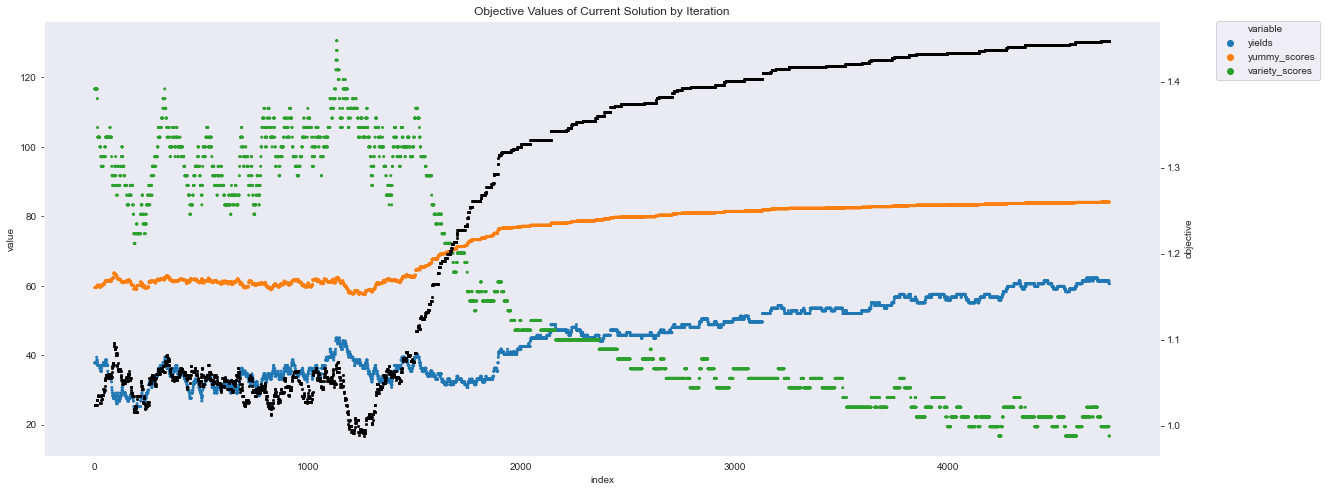

In [27]:
fig, ax = plt.subplots(figsize=(20,8))
sb.scatterplot(data=df,x='index',y='value',hue='variable',edgecolor=None,s=5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax2 = plt.twinx()
ax.set_title('Objective Values of Current Solution by Iteration')
sb.scatterplot(data=df.drop_duplicates(['index','total_plants']),x='index',y='objective',edgecolor=None,ax=ax2,color='black',s=5)

In [28]:
plant_info['plan'] = best_plan.sum(axis=(bed_axis,year_axis))

In [29]:
best_plan.sum(axis=bed_axis)

array([[ 0.,  0.,  0.],
       [12., 15., 15.],
       [13., 11., 14.],
       [ 0.,  0.,  2.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  1.],
       [ 0.,  1.,  1.],
       [ 0.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  0.,  2.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  3.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 0.,  1.,  1.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [30]:
plant_info

,plant,sun,perennial,avg_pref,plan
plant_index,,,,,
0,Arugula,Partial shade,0,6.5,0.0
1,Asparagus,Partial shade,1,9.5,42.0
2,Banana peppers,Full sun,0,9.5,38.0
3,Basil,Full sun,0,7.5,2.0
4,Bell peppers,Full sun,0,5.5,0.0
5,Blueberries,Full sun,1,5.5,1.0
6,Bok choy,Partial sun,0,5.5,1.0
7,Broccoli,Partial sun,0,5.5,1.0
8,Brussel sprouts,Partial shade,0,8.0,3.0


In [31]:
plant_info.groupby('sun').plan.sum()

sun
Full sun         73.0
Partial shade    46.0
Partial sun       7.0
Name: plan, dtype: float64

In [32]:
best_plan.shape

(36, 42, 3)

In [101]:
def annual_bed_plan(bed_info,best_plan):
    for t in year_index:
    bed_plan = []
    for b in bed_index:
        plant_idx = np.argmax(best_plan[:,b,t])
        plant = plant_info.iloc[plant_idx].plant
        bed_plan.append(plant)
    bed_info[f'year_{t+1}'] = pd.Series(bed_plan)
    return bed_info

IndentationError: expected an indented block (Temp/ipykernel_21160/1989566008.py, line 3)

In [34]:
bed_info

,bed,sun,x,y,year_1,year_2,year_3
bed_index,,,,,,,
0,1,Full sun,0,0,Banana peppers,Banana peppers,Banana peppers
1,2,Partial sun,1,0,Brussel sprouts,Butternut squash,Dill
2,3,Partial shade,2,0,Asparagus,Asparagus,Asparagus
3,4,Full sun,0,1,Broccoli,Kale,Banana peppers
4,5,Partial sun,1,1,Blueberries,Rasberries,Rasberries
5,6,Partial shade,2,1,Asparagus,Asparagus,Asparagus
6,7,Full sun,0,2,Banana peppers,Banana peppers,Banana peppers
7,8,Partial sun,1,2,Thyme,Chives,Chives
8,9,Partial shade,2,2,Asparagus,Asparagus,Asparagus


<AxesSubplot:>

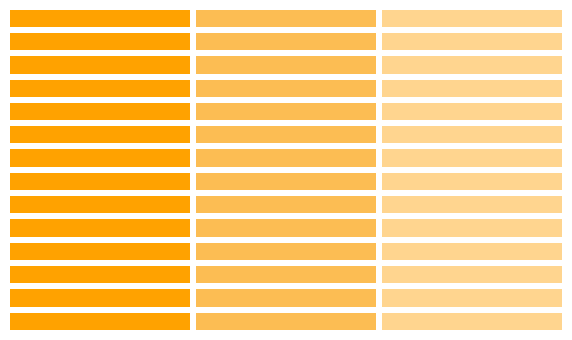

In [35]:
def visualize_garden(bed_info):
    garden_layout = bed_info.sun.map({'Full sun':1,'Partial sun':2,'Partial shade':3}).to_numpy().reshape(14,3)
    palette = ["#ffa200","#fcbd53","#ffd58f"]
    f, ax = plt.subplots(figsize=(10, 6))
    ax = sb.heatmap(garden_layout,linewidths=5,linecolor='white',cmap=sb.color_palette(palette),cbar=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plt.rcParams.update({'font.size': 13})
    return ax

visualize_garden(bed_info)

In [36]:
def visualize_plan(bed_index,bed_info,year):
    garden_viz = visualize_garden(bed_info)
    garden_viz.set_title(f'Year {year}')

    for bed in bed_index:
        x = bed_info.iloc[bed].x
        y = bed_info.iloc[bed].y
        plt.text(x + 0.5, y + 0.5, bed_info.loc[(bed_info.x==x)&(bed_info.y==y)][f'year_{year}'].iloc[0],
                        horizontalalignment='center',verticalalignment='center')

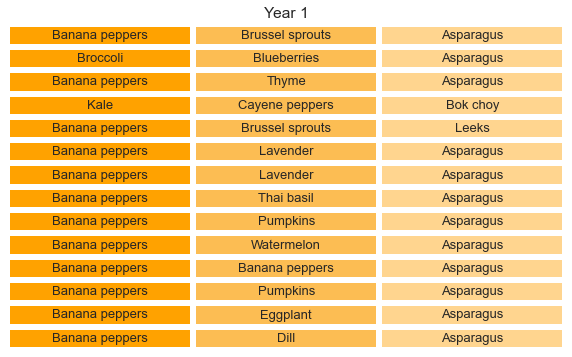

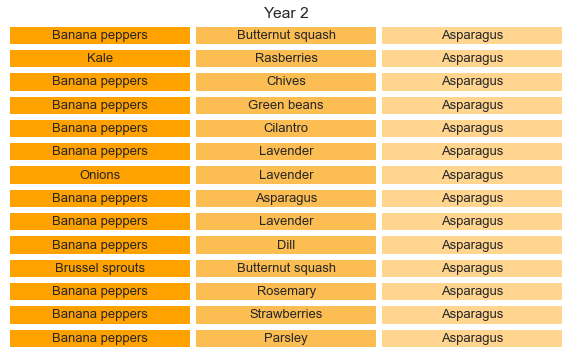

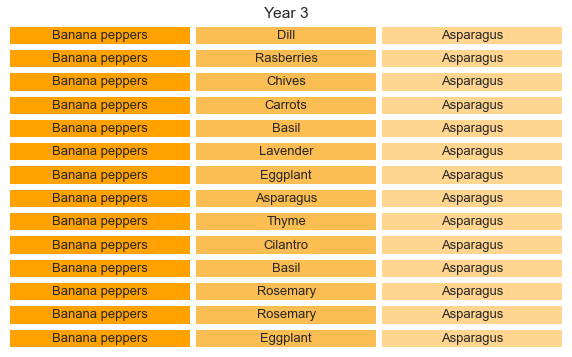

In [37]:
visualize_plan(bed_index,bed_info,year=1)
visualize_plan(bed_index,bed_info,year=2)
visualize_plan(bed_index,bed_info,year=3)

In [38]:
plant_info.sort_values('avg_pref',ascending=False)

,plant,sun,perennial,avg_pref,plan
plant_index,,,,,
2,Banana peppers,Full sun,0,9.5,38.0
1,Asparagus,Partial shade,1,9.5,42.0
9,Butternut squash,Full sun,0,8.5,2.0
28,Rasberries,Full sun,1,8.5,2.0
18,Green beans,Partial sun,0,8.0,1.0
8,Brussel sprouts,Partial shade,0,8.0,3.0
15,Cucumbers,Full sun,0,7.5,0.0
3,Basil,Full sun,0,7.5,2.0
33,Thyme,Full sun,1,7.0,2.0


In [39]:
best_plan[:,8,1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [40]:
best_plan[:,:,1].sum(plant_axis)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [41]:
best_plan.sum(axis=bed_axis)

array([[ 0.,  0.,  0.],
       [12., 15., 15.],
       [13., 11., 14.],
       [ 0.,  0.,  2.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  1.],
       [ 0.,  1.,  1.],
       [ 0.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  0.,  2.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  3.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 0.,  1.,  1.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]])

### Mixed Integer Programming

In [42]:
import gurobipy as grb

In [43]:
P = plant_index
B = bed_index
T = year_index

print('P (plants):')
print(P)
print()
print('B (beds):')
print(B)
print()
print('T (years):')
print(T)

P (plants):
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]

B (beds):
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]

T (years):
[0 1 2]


In [80]:
#create a model
try:
    m.reset()
except:
    m = grb.Model('optimus-veg')

Discarded solution information


#### Decision Variables

In [81]:
#whether or not plant (p) is put in bed (b) in year (t). Binary
x = m.addVars(P,B,T,vtype=grb.GRB.BINARY)
print(f'num vars: {len(x)}')
x

num vars: 4536


{(0, 0, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 0, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 0, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 1, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 2, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 3, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 4, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 1): <gurobi.Var *Awaiting Model Update*>,
 (0, 5, 2): <gurobi.Var *Awaiting Model Update*>,
 (0, 6, 0): <gurobi.Var *Awaiting Model Update*>,
 (0, 6, 1): <gurobi.Var *Awaiting Model Update*>,


In [82]:
#whether or not plant p is planted (anywhere)
y = m.addVars(plant_index,vtype=grb.GRB.BINARY)
len(y)

36

In [83]:
R = preferences
S = sun_constraint[:,:,0]

In [84]:
weights = {'yield_': 0.0, 'yummy_score': .5, 'variety_score': 0.01}

#### Objective

In [85]:
obj = m.setObjective((
    weights['yummy_score']*grb.quicksum(R[p]*x[p,b,t] for p in plant_index for b in bed_index for t in year_index) + 
    weights['variety_score']*grb.quicksum(y[p] for p in plant_index)
),grb.GRB.MAXIMIZE)

#### Constraints

In [86]:
onePerBedConstraint = m.addConstrs((grb.quicksum(x[p,b,t] for p in P) <= 1 for b in B for t in T))

In [87]:
sunConstraint = m.addConstrs((x[p,b,t]<=S[p,b] for p in P for b in B for t in T))

In [88]:
perennialConstraint = m.addConstrs(x[p,b,t]>=x[p,b,t-1] for p in P if p in perennials for b in B for t in T[1:])

In [92]:
#define y as it relates to x. You can only set y[p] to 1 if you actually plant it somewhere at some point
yxRelationConstraint = m.addConstrs((grb.quicksum(x[p,b,t] for b in B for t in T)>= y[p] for p in P))

### Solve

In [93]:
m.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 16614 rows, 13716 columns and 45972 nonzeros
Model fingerprint: 0xf0899f7c
Variable types: 0 continuous, 13716 integer (13716 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R16578 by 1.000000000

Found heuristic solution: objective 451.5300000
Presolve removed 16549 rows and 12979 columns
Presolve time: 0.02s
Presolved: 65 rows, 737 columns, 1451 nonzeros
Found heuristic solution: objective 567.0300000
Variable types: 0 continuous, 737 integer (737 binary)

Root relaxation: cutoff, 63 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 

In [94]:
counter = 0
for p in plant_index:
    counter+=y[p].x
counter

3.0

In [95]:
#get solution in same format as heuristic approach
mip_plan = np.zeros(shape=(num_plants,num_beds,num_years))

for p in plant_index:
    for b in bed_index:
        for t in year_index:
            if x[p,b,t].x==1:
                mip_plan[p,b,t] = 1

In [96]:
mip_plan.sum()

126.0

In [100]:
mip_bed_info = bed_info[['bed']].copy()

In [58]:
best_plan.sum()

126.0

In [59]:
bed_info

,bed,sun,x,y,year_1,year_2,year_3
bed_index,,,,,,,
0,1,Full sun,0,0,Banana peppers,Banana peppers,Banana peppers
1,2,Partial sun,1,0,Brussel sprouts,Butternut squash,Dill
2,3,Partial shade,2,0,Asparagus,Asparagus,Asparagus
3,4,Full sun,0,1,Broccoli,Kale,Banana peppers
4,5,Partial sun,1,1,Blueberries,Rasberries,Rasberries
5,6,Partial shade,2,1,Asparagus,Asparagus,Asparagus
6,7,Full sun,0,2,Banana peppers,Banana peppers,Banana peppers
7,8,Partial sun,1,2,Thyme,Chives,Chives
8,9,Partial shade,2,2,Asparagus,Asparagus,Asparagus


In [60]:
bed_info

,bed,sun,x,y,year_1,year_2,year_3
bed_index,,,,,,,
0,1,Full sun,0,0,Banana peppers,Banana peppers,Banana peppers
1,2,Partial sun,1,0,Brussel sprouts,Butternut squash,Dill
2,3,Partial shade,2,0,Asparagus,Asparagus,Asparagus
3,4,Full sun,0,1,Broccoli,Kale,Banana peppers
4,5,Partial sun,1,1,Blueberries,Rasberries,Rasberries
5,6,Partial shade,2,1,Asparagus,Asparagus,Asparagus
6,7,Full sun,0,2,Banana peppers,Banana peppers,Banana peppers
7,8,Partial sun,1,2,Thyme,Chives,Chives
8,9,Partial shade,2,2,Asparagus,Asparagus,Asparagus


In [61]:
x


{(0, 0, 0): <gurobi.Var C0 (value 0.0)>,
 (0, 0, 1): <gurobi.Var C1 (value 0.0)>,
 (0, 0, 2): <gurobi.Var C2 (value 0.0)>,
 (0, 1, 0): <gurobi.Var C3 (value 0.0)>,
 (0, 1, 1): <gurobi.Var C4 (value 0.0)>,
 (0, 1, 2): <gurobi.Var C5 (value 0.0)>,
 (0, 2, 0): <gurobi.Var C6 (value 0.0)>,
 (0, 2, 1): <gurobi.Var C7 (value 0.0)>,
 (0, 2, 2): <gurobi.Var C8 (value 0.0)>,
 (0, 3, 0): <gurobi.Var C9 (value 0.0)>,
 (0, 3, 1): <gurobi.Var C10 (value 0.0)>,
 (0, 3, 2): <gurobi.Var C11 (value 0.0)>,
 (0, 4, 0): <gurobi.Var C12 (value 0.0)>,
 (0, 4, 1): <gurobi.Var C13 (value 0.0)>,
 (0, 4, 2): <gurobi.Var C14 (value 0.0)>,
 (0, 5, 0): <gurobi.Var C15 (value 0.0)>,
 (0, 5, 1): <gurobi.Var C16 (value 0.0)>,
 (0, 5, 2): <gurobi.Var C17 (value 0.0)>,
 (0, 6, 0): <gurobi.Var C18 (value 0.0)>,
 (0, 6, 1): <gurobi.Var C19 (value 0.0)>,
 (0, 6, 2): <gurobi.Var C20 (value 0.0)>,
 (0, 7, 0): <gurobi.Var C21 (value 0.0)>,
 (0, 7, 1): <gurobi.Var C22 (value 0.0)>,
 (0, 7, 2): <gurobi.Var C23 (value 0.0)>,
 (

# Additional resources


NN architecture visualizer: http://alexlenail.me/NN-SVG/index.html